In [1]:
import torch
# from diffusers import AutoPipelineForImage2Image
from my_img2img import StableDiffusionImg2ImgPipeline
from diffusers.utils import make_image_grid, load_image

import numpy as np
import utils
from PIL import Image


/home/satoko5793/anaconda3/envs/glad/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
gauss = utils.get_3DGauss(sigma=3, mu=7.5)
print(gauss.sum)
# 将张量数据转换为 8 位整数
image_data = (gauss * 255).byte().numpy()

# 创建 PIL 图像对象
image = Image.fromarray(image_data)

# 显示图像

image_data.shape
image.save("./ss.png")
image

tensor(53.1200)
<built-in method sum of Tensor object at 0x7f85314d5f80>


In [3]:
MODULE_SIZE=16
MODULE_NUM=37
CODE_PATH = './inputs/code/qartcool.png'
IMAGE_SIZE = MODULE_SIZE * MODULE_NUM
code_img = utils.load_image(filename="./inputs/pattern/pattern_boy.png", size=IMAGE_SIZE)
qr_loss_scale = 0.04


In [5]:
# "../QR/rev/" is a local model, use "danbrown/RevAnimated-v1-2-2" instead for downloading from huggingface
pipeline = StableDiffusionImg2ImgPipeline.from_pretrained(
    "../QR/rev/", use_safetensors=True,MODULE_SIZE=MODULE_SIZE,MODULE_NUM=MODULE_NUM,CODE_PATH=CODE_PATH,qr_loss_scale=qr_loss_scale,
) 
pipeline.enable_model_cpu_offload()

Loading pipeline components...:  43%|████▎     | 3/7 [00:00<00:00,  9.99it/s]An error occurred while trying to fetch ../QR/rev/unet: Error no file named diffusion_pytorch_model.safetensors found in directory ../QR/rev/unet.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  71%|███████▏  | 5/7 [00:03<00:01,  1.48it/s]An error occurred while trying to fetch ../QR/rev/vae: Error no file named diffusion_pytorch_model.safetensors found in directory ../QR/rev/vae.
Defaulting to unsafe serialization. Pass `allow_pickle=False` to raise an error instead.
Loading pipeline components...:  86%|████████▌ | 6/7 [00:03<00:00,  1.77it/s]/home/satoko5793/anaconda3/envs/glad/lib/python3.10/site-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(
Loading pip

tensor(85.8000)


In [6]:

# prepare image
init_image = load_image("./inputs/ref/boy.png")
init_image = init_image.resize((IMAGE_SIZE,IMAGE_SIZE))


prompt = "solo, glasses, black hair, male focus, 1boy, realistic,  black eyes, shirt, short hair, looking at viewer, upper body, lips, traditional media, collared shirt，cloud, masterpiece, best quality, best quality, ultra high res, above the clouds(((cloud))), foggy, grass, solo, looking up, clear sky, summer, ((sunset)), blue sky, lonely, heartfelt, (your name meteor:0.8)"
negative_prompt = "cartoon, anime, sketches,(worst quality, low quality), (deformed, distorted, disfigured, bad eyes), wrong nose, weird mouth, strange ears, bad anatomy, wrong anatomy, amputation, extra limb, missing limb, floating limbs, (bad teeth, mutated hands, wrong fingers:1.2), disconnected limbs, mutation, ugly, disgusting, negative_hand-neg, bad_pictures"


In [7]:
# lora_path = "../stable-diffusion-webui/models/Lora/NESVoxelStyle.safetensors"
# # pipeline.load_lora_weights(lora_path)
# # lora_path1 = "../stable-diffusion-webui/models/Lora/blindbox_v1_mix.safetensors"
# # pipeline.load_lora_weights(lora_path1)

# pipeline.unload_lora_weights()

# lora_w = 1.0
# pipeline._lora_scale = lora_w

# state_dict, network_alphas = pipeline.lora_state_dict(
#     lora_path
# )

# for key in network_alphas:
#     network_alphas[key] = network_alphas[key] * lora_w

# #network_alpha = network_alpha * lora_w
# pipeline.load_lora_into_unet(
#     state_dict = state_dict
#     , network_alphas = network_alphas
#     , unet = pipeline.unet
# )

# pipeline.load_lora_into_text_encoder(
#     state_dict = state_dict
#     , network_alphas = network_alphas
#     , text_encoder = pipeline.text_encoder
# )

In [8]:
def add_pattern(target_PIL, code_PIL, module_number=37, module_size=16):
    target_img = np.asarray(target_PIL)
    code_img = np.array(code_PIL)
    output = target_img
    output = np.require(output, dtype='uint8', requirements=['O', 'W'])
    ms = module_size  # module size
    mn = module_number  # module_number
    output[0 * ms:(8 * ms) - 1, 0 * ms:(8 * ms) - 1, :] = code_img[0 * ms:(8 * ms) - 1, 0 * ms:(8 * ms) - 1, :]
    output[((mn - 8) * ms) + 1:(mn * ms), 0 * ms:(8 * ms) - 1, :] = code_img[((mn - 8) * ms) + 1:(mn * ms),
                                                                    0 * ms:(8 * ms) - 1,
                                                                    :]
    output[0 * ms: (8 * ms) - 1, ((mn - 8) * ms) + 1:(mn * ms), :] = code_img[0 * ms: (8 * ms) - 1,
                                                                     ((mn - 8) * ms) + 1:(mn * ms), :]
    output[28 * ms: (33 * ms) - 1, 28 * ms:(33 * ms) - 1, :] = code_img[28 * ms: (33 * ms) - 1, 28 * ms:(33 * ms) - 1,
                                                               :]

    output = Image.fromarray(output.astype('uint8'))
    # print('Added finder and alignment patterns.')
    return output

In [10]:
import shutil
import os
shutil.rmtree('./steps')  
os.mkdir('./steps')

In [11]:
# pass prompt and image to pipeline
image = pipeline(prompt,negative_prompt=negative_prompt, image=init_image,strength=0.2,num_inference_steps=200,Dis=50).images[0]
image.save("./output.png")


Token indices sequence length is longer than the specified maximum sequence length for this model (98 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: [', (( sunset )), blue sky, lonely, heartfelt, ( your name meteor : 0. 8 )']
  0%|          | 0/40 [00:00<?, ?it/s]

0 activate_num 979.0 lr 0.042 loss: 7312.8134765625


  8%|▊         | 3/40 [00:07<01:33,  2.54s/it]

3 activate_num 952.0 lr 0.04862025000000002 loss: 4141.18115234375


 15%|█▌        | 6/40 [00:15<01:21,  2.40s/it]

6 activate_num 755.0 lr 0.056284016906250026 loss: 2038.206298828125


 22%|██▎       | 9/40 [00:22<01:12,  2.34s/it]

mean_grayscale 128
9 activate_num 392.0 lr 0.06515578507109769 loss: 634.1241455078125


 30%|███       | 12/40 [00:29<01:04,  2.30s/it]

12 activate_num 160.0 lr 0.07542596569292946 loss: 155.17457580566406


 38%|███▊      | 15/40 [00:35<00:56,  2.27s/it]

15 activate_num 81.0 lr 0.08731498353527747 loss: 68.9427261352539


 45%|████▌     | 18/40 [00:42<00:48,  2.22s/it]

18 activate_num 70.0 lr 0.1010780078150256 loss: 65.13075256347656


 50%|█████     | 20/40 [00:47<00:44,  2.25s/it]

mean_grayscale 128


 52%|█████▎    | 21/40 [00:49<00:42,  2.23s/it]

21 activate_num 38.0 lr 0.11701042879686901 loss: 43.126373291015625


 60%|██████    | 24/40 [00:56<00:35,  2.23s/it]

24 activate_num 58.0 lr 0.1354541976359755 loss: 56.2451286315918


 68%|██████▊   | 27/40 [01:02<00:28,  2.23s/it]

27 activate_num 19.0 lr 0.15680516553834617 loss: 14.507022857666016


 75%|███████▌  | 30/40 [01:09<00:22,  2.23s/it]

mean_grayscale 128
30 activate_num 29.0 lr 0.181521579756328 loss: 27.49262809753418


 85%|████████▌ | 34/40 [01:19<00:14,  2.37s/it]

33 activate_num 20.0 lr 0.2101339187654192 loss: 21.071752548217773


 90%|█████████ | 36/40 [01:23<00:09,  2.29s/it]

36 activate_num 23.0 lr 0.24325627771081845 loss: 18.50521469116211


 98%|█████████▊| 39/40 [01:30<00:02,  2.21s/it]

mean_grayscale 128
39 activate_num 2.0 lr 0.2554190915963594 loss: 1.4501410722732544


100%|██████████| 40/40 [01:32<00:00,  2.32s/it]


In [12]:

Img = image.convert('L')
# Img.save("test1.jpg")
 
# 自定义灰度界限，大于这个值为黑色，小于这个值为白色
threshold = 128
 
table = []
for i in range(256):
    if i < threshold:
        table.append(0)
    else:
        table.append(1)
 
# 图片二值化
photo = Img.point(table, '1')
photo.save("./binary.png")

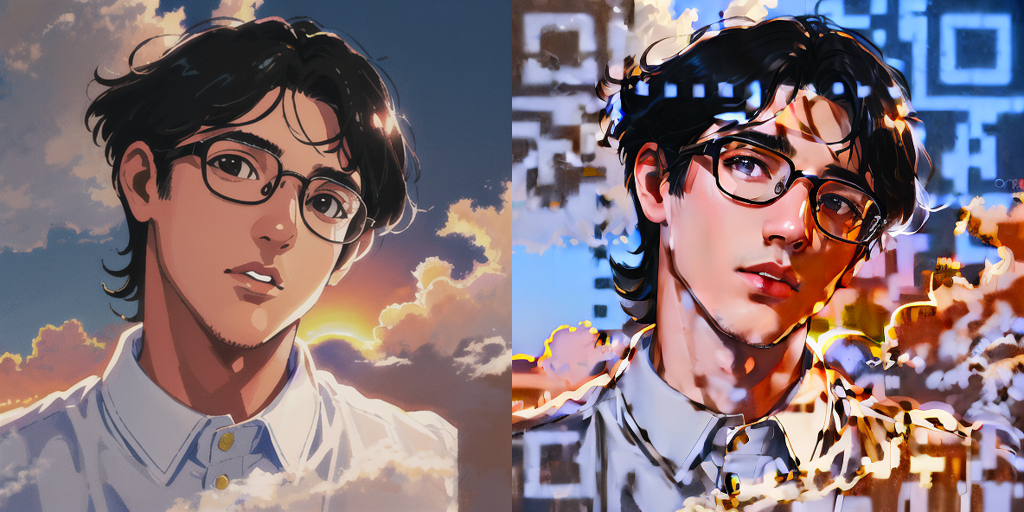

In [13]:
make_image_grid([init_image.resize((512,512)), image.resize((512,512))], rows=1, cols=2)

In [15]:
from SS_layer import SSlayer
ss_layer = SSlayer(requires_grad=False).cuda()
code_img = utils.load_image(filename=CODE_PATH, size=IMAGE_SIZE)

tensor(85.8000)


In [17]:
from PIL import ImageDraw
def rescale(array):
    return (array - array.min()) * (255.0 / (array.max() - array.min()))

def get_mask(original_array, ideal_result=None, transparency=0.9):
    # 定义放大倍数
    enlarge_factor = MODULE_SIZE

    original_array[0:2,:] = 0
    original_array[MODULE_NUM-2:MODULE_NUM,:] = 0
    original_array[:,0:2] = 0
    original_array[:,MODULE_NUM-2:MODULE_NUM] = 0

    # 扩充原始数组
    enlarged_array = np.kron(original_array, np.ones((enlarge_factor, enlarge_factor)))

    # 定义圆圈半径和颜色
    radius = 4
    force_radius = 2
    circle_color = (255) 

    # 计算圆心在放大后的中心位置
    centers = [(r * enlarge_factor + enlarge_factor // 2, c * enlarge_factor + enlarge_factor // 2, ideal_result[r, c])
            for r in range(original_array.shape[0])
            for c in range(original_array.shape[1])
            if original_array[r, c] == 1]

    # 创建PIL Image
    image = Image.fromarray((np.zeros_like(enlarged_array) * 255).astype(np.uint8), mode='L')

    # 创建一个RGBA图像，以支持透明度
    new_image = Image.new('RGBA', image.size, (255, 255, 255, 0))

    # 创建Draw对象，并在图像上绘制圆圈
    draw = ImageDraw.Draw(image)
    draw1 = ImageDraw.Draw(new_image)
    for center in centers:
        draw.ellipse([center[1] - radius, center[0] - radius, center[1] + radius, center[0] + radius], fill=circle_color)
        if center[2]==1:
            draw1.ellipse([center[1] - force_radius, center[0] - force_radius, center[1] + force_radius, center[0] + force_radius], fill=(255, 255, 255, int(255 * (1 - transparency))))
        else:
            draw1.ellipse([center[1] - force_radius, center[0] - force_radius, center[1] + force_radius, center[0] + force_radius], fill=(0, 0, 0, int(255 * (1 - transparency))))
    
    return image, new_image


def QR_loss(images, Dis=30, step=0, Correct_b=50, Correct_w=200, CODE_WEIGHT=0.3):
    images.data.clamp_(0, 1)
    code_y = ss_layer(images)
    # 去除单维度
    tensor_squeezed = code_y.squeeze()
    # 转换为 NumPy 数组
    center_mat = tensor_squeezed.cpu().detach().numpy() * 255 / ss_layer.total_weight / 3  # sum of z in get_3DGauss

    image_data = center_mat.astype("uint8")
    mean_grayscale = image_data.mean()
    mean_grayscale = 128
    # mean_grayscale = 95
    Dis_b = max(mean_grayscale - Dis, 30)
    Dis_w = min(mean_grayscale + Dis, 220)
    # Dis_b = 80
    # Dis_w = 200

    error_matrix, ideal_result = utils.get_action_matrix(
        img_target=utils.tensor_to_PIL(images),
        img_code=code_img,
        center_mat=center_mat,
        IMG_SIZE=IMAGE_SIZE,
        Dis_b=Dis_b, Dis_w=Dis_w
    )
    image3, mask_t = get_mask(error_matrix, ideal_result, 0.2)
    resized_image3 = image3
    img = Image.fromarray(image_data, 'L')
    resized_img = img.resize((IMAGE_SIZE, IMAGE_SIZE), Image.BOX)
    resized_img.save("./cur-feature.png")
    
    return resized_image3, mask_t

In [19]:
def add_pattern(target_PIL, code_PIL, module_number=37, module_size=16, pad=2):
    target_img = np.asarray(target_PIL)
    code_img = np.array(code_PIL)
    print(target_img.shape, code_img.shape)
    output = target_img
    output = np.require(output, dtype='uint8', requirements=['O', 'W'])
    ms = module_size  # module size
    mn = module_number  # module_number
    mi = max(0,pad-1)
    output[mi * ms:((8+pad) * ms) - 1, mi * ms:((8+pad) * ms) - 1, :] = code_img[mi * ms:((8+pad) * ms) - 1, mi * ms:((8+pad) * ms) - 1, :]
    output[((mn - (8+pad)) * ms) + 1:((mn-mi) * ms), mi * ms:((8+pad) * ms) - 1, :] = code_img[((mn - (8+pad)) * ms) + 1:((mn-mi) * ms), mi * ms:((8+pad) * ms) - 1, :]
    output[mi * ms: ((8+pad) * ms) - 1, ((mn - (8+pad)) * ms) + 1:((mn-mi) * ms), :] = code_img[mi * ms: ((8+pad) * ms) - 1, ((mn - (8+pad)) * ms) + 1:((mn-mi) * ms), :]
    output[(28+pad) * ms: ((33+pad) * ms) - 1, (28+pad) * ms:((33+pad) * ms) - 1, :] = code_img[(28+pad) * ms: ((33+pad) * ms) - 1, (28+pad) * ms:((33+pad) * ms) - 1, :]

    output = Image.fromarray(output.astype('uint8'))
    print('Added finder and alignment patterns.')
    return output

(592, 592, 3) (592, 592, 3)
Added finder and alignment patterns.


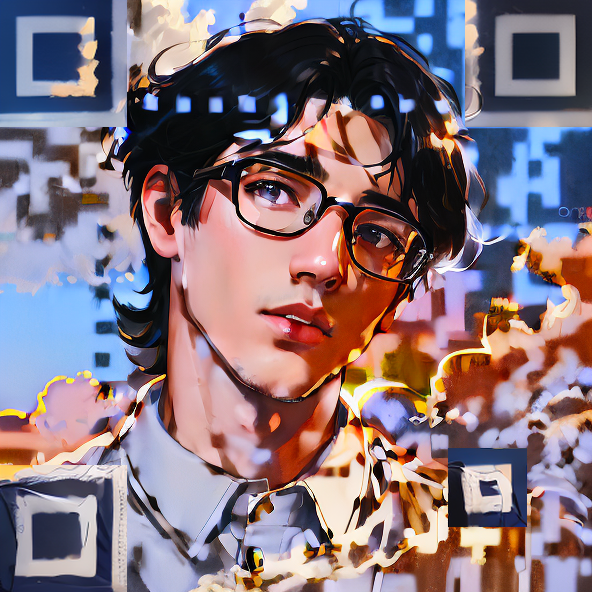

In [21]:
pattern_img = utils.load_image(filename="./inputs/pattern/pattern_boy.png", size=IMAGE_SIZE)
output = add_pattern(image, pattern_img,module_number=MODULE_NUM, pad=0)
output.save("./output-p.png")
display(output)

In [24]:
from PIL import Image, ImageEnhance, ImageFilter, ImageOps

def enhance_contrast_pil(image):
    # Open RGB image using PIL
    img = image

    # Convert RGB to grayscale
    gray_img = ImageOps.grayscale(img)

    # Calculate the average grayscale value
    mean_intensity = np.mean(np.array(gray_img))

    # Create an enhancer object
    enhancer = ImageEnhance.Contrast(img)

    # Adjust the contrast based on the average grayscale value
    enhanced_img = enhancer.enhance(1.3)  # You can adjust the factor as needed
    enhanced_img.save('./output-c.png')

    # Apply Gaussian blur
    blurred_img = enhanced_img.filter(ImageFilter.GaussianBlur(radius=1))  # Adjust the radius as needed

    # Display original and enhanced contrast images
    # img.show(title='Original Image')
    display(img)
    # enhanced_img.show(title='Enhanced Contrast Image')
    # blurred_img.show(title='Blured Image')
    display(blurred_img)
    display(enhanced_img)
    # Save the enhanced contrast image
    blurred_img.save('./output-b.png')

    # code_img = utils.load_image(filename=CODE_PATH, size=IMAGE_SIZE)
    # code_img = utils.load_image(filename="./qr_output/ijcai/yamato/code-3.png", size=IMAGE_SIZE)
    # Create an enhancer object
    # enhancer1 = ImageEnhance.Contrast(code_img)

    # Adjust the contrast based on the average grayscale value
    # code_img = enhancer1.enhance(1.3)  # You can adjust the factor as needed

    # output = add_pattern(blurred_img, code_img,module_number=MODULE_NUM)
    # output.save("./output-p.png")
    # output.show()

    image_array = np.array(enhanced_img)
    image_tensor = torch.from_numpy(image_array).float() / 255.0
    image_tensor = image_tensor.permute(2, 0, 1).cuda()
    image_tensor.shape
    mask, t_mask = QR_loss(image_tensor, Dis=80)
    # mask.resize((256,256)).show()
    display(mask.resize((256,256)))
    # t_mask.resize((256,256)).show()
    display(t_mask.resize((256,256)))
    img_m = Image.alpha_composite(img.convert('RGBA'), t_mask)
    img_m.save('./output-m.png')
    img_em = Image.alpha_composite(enhanced_img.convert('RGBA'), t_mask)
    img_em.save('./output-em.png')
    bm_img = img_em.filter(ImageFilter.GaussianBlur(radius=0.5))  # Adjust the radius as needed
    bm_img.save('./output-bm.png')

    blurred_mask = mask.filter(ImageFilter.GaussianBlur(1)) # blur_radius
    # 将蒙版应用到原始图像上
    result_image = Image.new("RGBA", img.size, (0, 0, 0, 0))
    result_image.paste(enhanced_img, (0, 0))
    result_image.paste(blurred_img, (0, 0), mask=blurred_mask)

    # 保存结果
    result_image.save('./output-bp.png')
    display(result_image)

    # 将蒙版应用到原始图像上
    result_image = Image.new("RGBA", img.size, (0, 0, 0, 0))
    result_image.paste(img_em, (0, 0))
    result_image.paste(bm_img, (0, 0), mask=blurred_mask)

    # 保存结果
    result_image.save('./output-bpm.png')

# Example usage
# enhance_contrast_pil(image)

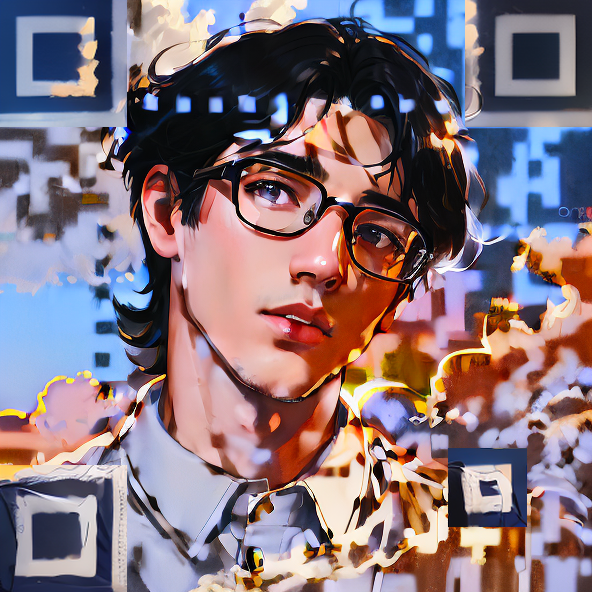

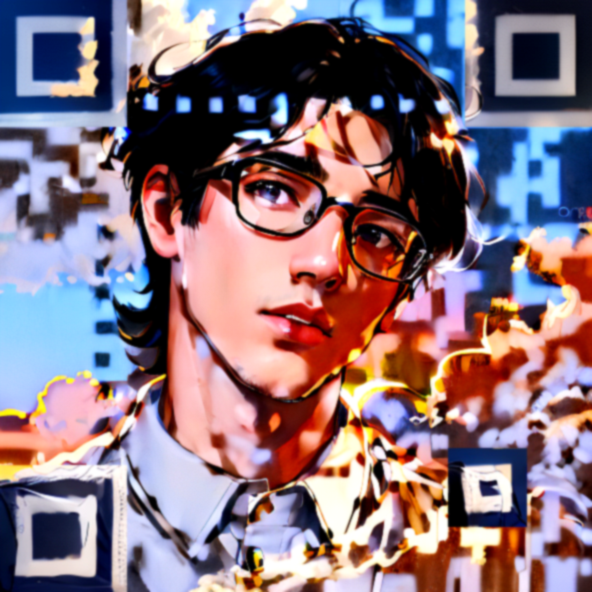

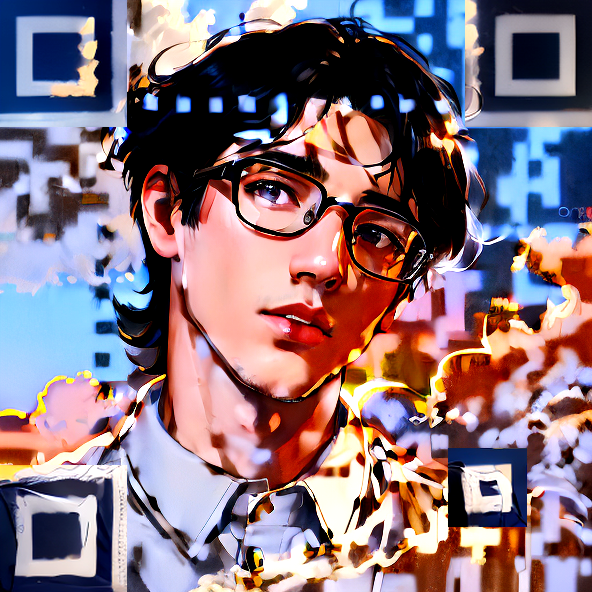

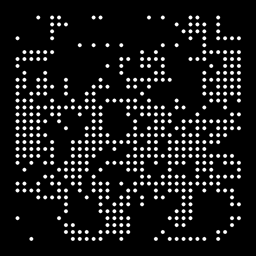

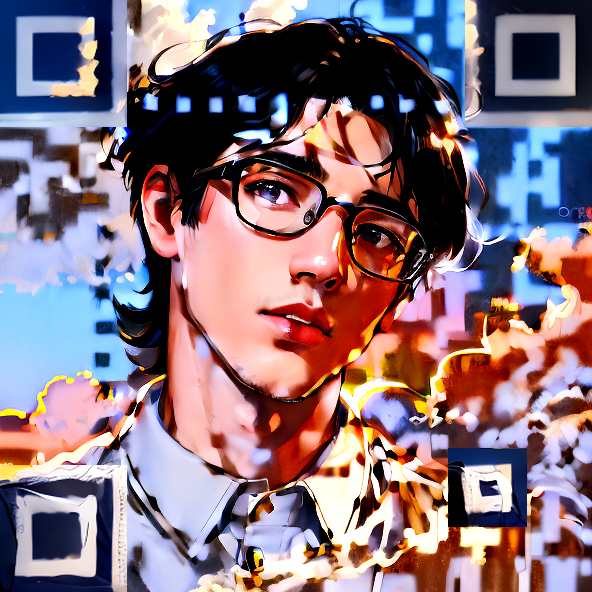

In [25]:
enhance_contrast_pil(output)